In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, log_loss,
    roc_auc_score
)
from sklearn.model_selection import train_test_split

In [2]:
train = pd.DataFrame(pd.read_csv('fashion-mnist_train.csv'))
X = train.drop('label',axis = 1)
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Training data: (48000, 784) (48000,)
Test data: (12000, 784) (12000,)


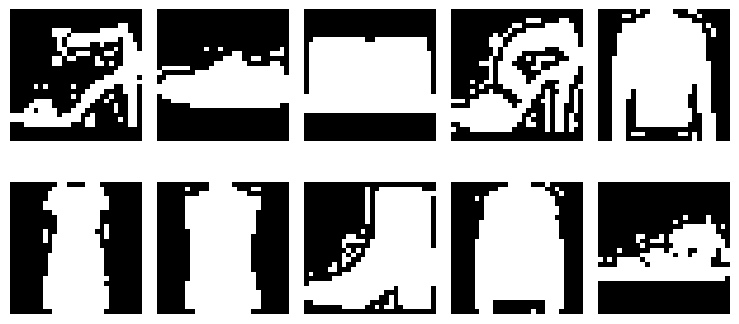

In [3]:
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
print("Training data: {} {}".format(X_train.shape, y_train.shape))
print("Test data: {} {}".format(X_val.shape, y_val.shape))
show_images(X_train)

Epoch 0, Loss: 1.7300
Epoch 10, Loss: 0.4640
Epoch 20, Loss: 0.3932
Epoch 30, Loss: 0.3513
Epoch 40, Loss: 0.3303
Epoch 50, Loss: 0.3129
Epoch 60, Loss: 0.2959
Epoch 70, Loss: 0.2912
Epoch 80, Loss: 0.2793
Epoch 90, Loss: 0.2744
Epoch 100, Loss: 0.2692
Epoch 110, Loss: 0.2626
Epoch 120, Loss: 0.2570
Epoch 130, Loss: 0.2548
Epoch 140, Loss: 0.2488
Epoch 150, Loss: 0.2449
Epoch 160, Loss: 0.2440
Epoch 170, Loss: 0.2333
Epoch 180, Loss: 0.2313
Epoch 190, Loss: 0.2238
Epoch 200, Loss: 0.2266
Epoch 210, Loss: 0.2295
Epoch 220, Loss: 0.2228
Epoch 230, Loss: 0.2139
Epoch 240, Loss: 0.2195


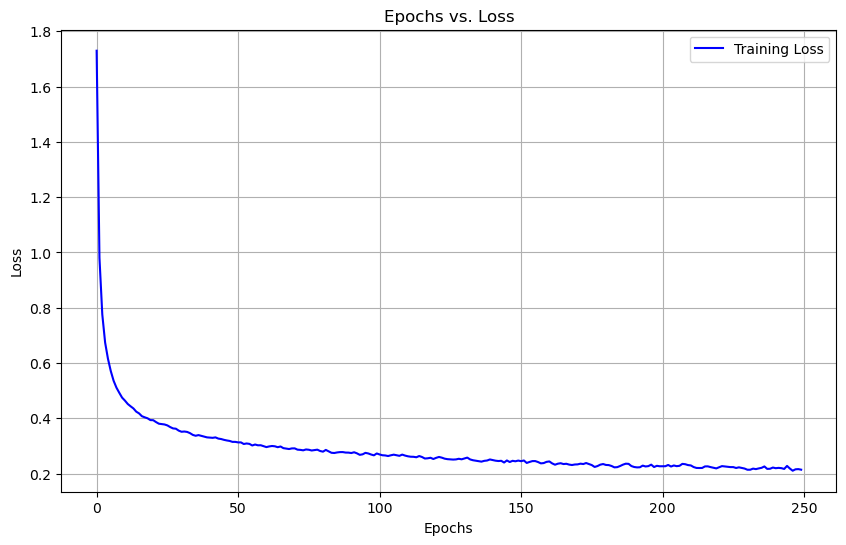

Test Accuracy: 0.88


In [4]:
# Helper functions
def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function."""
    return z > 0

def softmax(z):
    """Softmax activation function."""
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """Cross-entropy loss."""
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(n_samples), y_true])
    return np.mean(log_likelihood)

def one_hot_encode(y, num_classes):
    """One-hot encode labels."""
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Initialize parameters
def initialize_parameters(input_size, hidden_layer1, hidden_layer2, output_size):
    np.random.seed(42)
    params = {
        "W1": np.random.randn(input_size, hidden_layer1) * 0.01,
        "b1": np.zeros((1, hidden_layer1)),
        "W2": np.random.randn(hidden_layer1, hidden_layer2) * 0.01,
        "b2": np.zeros((1, hidden_layer2)),
        "W3": np.random.randn(hidden_layer2, output_size) * 0.01,
        "b3": np.zeros((1, output_size)),
    }
    return params

def dropout_forward(A, keep_prob):
    """Apply dropout to the activations."""
    D = (np.random.rand(*A.shape) < keep_prob).astype(float)  # Dropout mask
    A *= D  # Apply mask
    A /= keep_prob  # Scale activations
    return A, D

# Forward propagation with dropout
def forward_propagation(X, params, keep_prob1=1.0, keep_prob2=1.0):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = relu(Z1)
    A1, D1 = dropout_forward(A1, keep_prob1)  # Apply dropout to first hidden layer
    
    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = relu(Z2)
    A2, D2 = dropout_forward(A2, keep_prob2)  # Apply dropout to second hidden layer
    
    Z3 = np.dot(A2, params["W3"]) + params["b3"]
    A3 = softmax(Z3)
    
    cache = {
        "Z1": Z1, "A1": A1, "D1": D1,  # Include dropout mask
        "Z2": Z2, "A2": A2, "D2": D2,  # Include dropout mask
        "Z3": Z3, "A3": A3,
    }
    return A3, cache

# Backward propagation with dropout
def backward_propagation(X, y, params, cache, keep_prob1=1.0, keep_prob2=1.0):
    m = X.shape[0]
    Y_one_hot = one_hot_encode(y, params["b3"].shape[1])
    
    dZ3 = cache["A3"] - Y_one_hot
    dW3 = np.dot(cache["A2"].T, dZ3) / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    dA2 = np.dot(dZ3, params["W3"].T)
    dA2 *= cache["D2"]  # Apply dropout mask
    dA2 /= keep_prob2  # Scale activations
    dZ2 = dA2 * relu_derivative(cache["Z2"])
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = np.dot(dZ2, params["W2"].T)
    dA1 *= cache["D1"]  # Apply dropout mask
    dA1 /= keep_prob1  # Scale activations
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads


# Adam optimization
def adam_optimizer(params, grads, learning_rate, beta1, beta2, epsilon, t, m, v):
    """
    Adam optimization algorithm.
    m: moving average of the gradients (for momentum)
    v: moving average of the squared gradients (for variance)
    t: time step
    """
    for key in params.keys():
        if key.startswith("W") or key.startswith("b"):
            # Update moving averages for each parameter
            m[key] = beta1 * m[key] + (1 - beta1) * grads["d" + key]
            v[key] = beta2 * v[key] + (1 - beta2) * (grads["d" + key] ** 2)
            
            # Compute bias-corrected estimates
            m_hat = m[key] / (1 - beta1 ** t)
            v_hat = v[key] / (1 - beta2 ** t)
            
            # Update parameters
            params[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return params, m, v

# Mini-batch gradient descent with Adam
# Train function with added tracking for loss
def train(X, y, input_size, hidden_layer1, hidden_layer2, output_size, epochs, learning_rate, batch_size, keep_prob1=1.0, keep_prob2=1.0, beta1=0.9, beta2=0.999, epsilon=1e-8):
    params = initialize_parameters(input_size, hidden_layer1, hidden_layer2, output_size)
    
    m = {key: np.zeros_like(value) for key, value in params.items()}
    v = {key: np.zeros_like(value) for key, value in params.items()}
    
    epoch_losses = []  # List to store loss at each epoch
    
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for i in range(0, X.shape[0], batch_size):
            # Get mini-batch
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Forward propagation
            A3, cache = forward_propagation(X_batch, params, keep_prob1, keep_prob2)
            
            # Compute loss
            loss = cross_entropy_loss(y_batch, A3)
            epoch_loss += loss
            num_batches += 1
            
            # Backward propagation
            grads = backward_propagation(X_batch, y_batch, params, cache, keep_prob1, keep_prob2)
            
            # Adam optimization to update parameters
            t = epoch * (X.shape[0] // batch_size) + (i // batch_size) + 1
            params, m, v = adam_optimizer(params, grads, learning_rate, beta1, beta2, epsilon, t, m, v)
        
        epoch_loss /= num_batches  # Average loss for the epoch
        epoch_losses.append(epoch_loss)  # Store the epoch loss
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
    
    # Plot epoch vs. loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), epoch_losses, label="Training Loss", color="blue")
    plt.title("Epochs vs. Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
    return params


# Prediction
def predict(X, params):
    A3, _ = forward_propagation(X, params)
    return np.argmax(A3, axis=1)
    
params = train(X_train, y_train, 784, 64, 32, 10, epochs=250, learning_rate=0.001, batch_size=4096, keep_prob1=0.8, keep_prob2=0.7)


# Predict and calculate accuracy
predictions = predict(X_val, params)
accuracy = np.mean(predictions == y_val)
print(f"Test Accuracy: {accuracy:.2f}")

In [5]:
def multiclass_classification_metrics(y_true, y_pred, y_probs=None):
    """
    Compute various metrics for multiclass classification.
    
    Parameters:
    - y_true: Ground truth (true labels).
    - y_pred: Predicted labels.
    
    Returns:
    - metrics_dict: Dictionary containing all computed metrics.
    """
    metrics_dict = {}
    
    # General Metrics
    metrics_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1-Score
    metrics_dict['Precision (Macro)'] = precision_score(y_true, y_pred, average='macro')
    metrics_dict['Precision (Weighted)'] = precision_score(y_true, y_pred, average='weighted')
    metrics_dict['Recall (Macro)'] = recall_score(y_true, y_pred, average='macro')
    metrics_dict['Recall (Weighted)'] = recall_score(y_true, y_pred, average='weighted')
    metrics_dict['F1-Score (Macro)'] = f1_score(y_true, y_pred, average='macro')
    metrics_dict['F1-Score (Weighted)'] = f1_score(y_true, y_pred, average='weighted')
    
    # Confusion Matrix
    metrics_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred)
    
    # Classification Report
    metrics_dict['Classification Report'] = classification_report(y_true, y_pred)
    
    return metrics_dict

In [6]:
metrics = multiclass_classification_metrics(y_val, predictions)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Accuracy: 0.8808333333333334
Precision (Macro): 0.8819699320898884
Precision (Weighted): 0.880687304363074
Recall (Macro): 0.8823943602167887
Recall (Weighted): 0.8808333333333334
F1-Score (Macro): 0.8811390056089987
F1-Score (Weighted): 0.8796931376960605
Confusion Matrix: [[1041    3   21   55    5    0  102    0    5    0]
 [   3 1127    7   36    0    0    0    0    1    0]
 [   9    1  973   11  137    0   63    0    6    0]
 [  16   13    9 1123   66    0   12    0    3    0]
 [   2    1   81   42  998    1   56    0    4    0]
 [   0    0    0    0    0 1092    0   25    2   22]
 [ 180    2  108   42  117    1  778    0   14    1]
 [   0    0    0    0    0   26    0 1179    1   18]
 [  10    0    4    4    2   10    8    2 1109    0]
 [   0    0    1    0    0    9    0   49    1 1150]]
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1232
           1       0.98      0.96      0.97      1174
        

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix using Seaborn for visualization.
    
    Parameters:
    - y_true: Ground truth (true labels).
    - y_pred: Predicted labels.
    - class_names: List of class names for the labels.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # Add labels and title
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


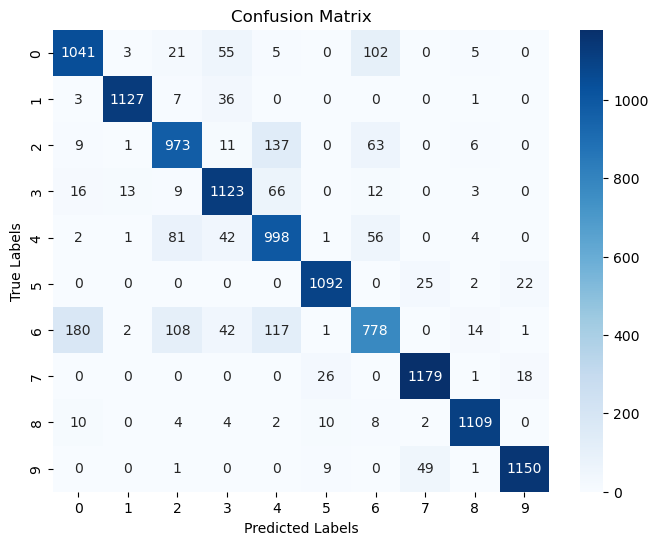

In [8]:
class_names =  [0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(y_val, predictions, class_names)

In [9]:
test = pd.DataFrame(pd.read_csv('fashion-mnist_test.csv'))
X_test = test.drop('label',axis = 1)
y_test = test['label']
predictions = predict(X_test, params)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.2f}")
metrics = multiclass_classification_metrics(y_test, predictions)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Test Accuracy: 0.88
Accuracy: 0.884
Precision (Macro): 0.8833339525698335
Precision (Weighted): 0.8833339525698335
Recall (Macro): 0.884
Recall (Weighted): 0.884
F1-Score (Macro): 0.883119759793766
F1-Score (Weighted): 0.8831197597937659
Confusion Matrix: [[839   0  16  40   1   0  96   0   8   0]
 [  5 978   3  10   2   1   1   0   0   0]
 [ 14   1 788  16 113   0  66   0   2   0]
 [ 20  14   9 909  26   0  19   0   3   0]
 [  0   1  64  29 865   0  39   0   2   0]
 [  1   0   1   0   0 942   0  34   4  18]
 [142   2  70  36  85   0 652   0  13   0]
 [  0   0   0   0   0  22   0 954   0  24]
 [  7   0   6   0   2   8  13   3 961   0]
 [  0   0   0   0   0   6   0  42   0 952]]
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.79      0.81      1000
           3       0.87      0.91      0.89      1000
           4       